# Accuracy Comparison

In [262]:
# Standard packages
import pickle
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import collections  as mc
import statistics

# Local packages
from simulate import *

In [301]:
# Load data. Less than 2 MiB.
# Data aggregated over 5 runs, up to 100ms of simulation
with open('parrot-traces/polybench-mf-jun14-optimized/polybench-mf-jun14-optimized.pkl', 'rb') as file:
    mf = pickle.load(file)
with open('parrot-traces/polybench-normal-jun14/polybench-normal-jun14.pkl', 'rb') as file:
    norm = pickle.load(file)

In [302]:
mf.st['2mm'].ipc[0]

0.6477731582388658

In [303]:
names = list(mf.st.keys())
y_norm_ipc  = [norm.st[n].ipc[0] for n in names]
y_mf_ipc    = [mf.st[n].ipc[0]   for n in names]
y_mfn_ipc   = [mf_n.st[n].ipc[0]   for n in names]

KeyError: '3mm'

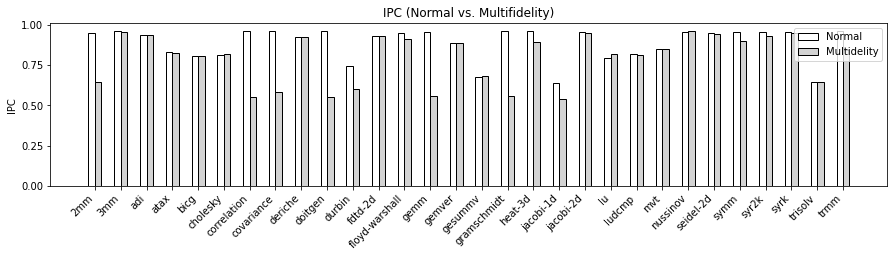

In [304]:
x = np.arange(len(names))
width = 0.25
fig, ax = plt.subplots()
ax.bar(x-width/2, y_norm_ipc, width, color='white', label='Normal', edgecolor='black')
ax.bar(x+width/2, y_mf_ipc, width, color='lightgrey', label='Multidelity', edgecolor='black')
#ax.bar(x+width, y_mfn_ipc, width, color='lightblue', label='Multidelity New', edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(names, rotation=45, ha='right')
ax.set_ylim((0,1))
ax.set_ylabel('IPC', rotation=90)
ax.set_title('IPC (Normal vs. Multifidelity)')
ax.autoscale()
plt.legend()

#ax.yaxis.set_label_coords(-.07, 0.96)
nyticks = 5
ax.set_yticks([(1/(nyticks-1))*x for x in np.arange(nyticks)])
fig.set_size_inches((15,3))
fig.savefig('plots/ipc-normal-vs-mf.png')
#plt.tight_layout()

In [305]:
pct_err = []

def p_err(approx, exact):
    return (approx-exact)/exact * 100
def mape(arr):
    return np.mean(np.absolute(arr))

print('Percent error\n')
name_len = max([len(name) for name in names])
for (i, name) in enumerate(names):
    pe = p_err(y_mf_ipc[i], y_norm_ipc[i])
    pct_err.append(pe)
    print(f'{i}'.ljust(2), f'{name}'.ljust(name_len), f'{pe: 06.2f}%')
    
print(f'\nMAPE: {mape(pct_err):.2f}%')

Percent error

0  2mm            -31.97%
1  3mm            -00.33%
2  adi            -00.12%
3  atax           -00.37%
4  bicg            00.29%
5  cholesky        00.92%
6  correlation    -42.30%
7  covariance     -39.11%
8  deriche        -00.34%
9  doitgen        -42.58%
10 durbin         -19.15%
11 fdtd-2d        -00.25%
12 floyd-warshall -03.89%
13 gemm           -41.78%
14 gemver         -00.26%
15 gesummv         00.99%
16 gramschmidt    -42.07%
17 heat-3d        -07.48%
18 jacobi-1d      -15.40%
19 jacobi-2d      -00.12%
20 lu              03.30%
21 ludcmp         -00.65%
22 mvt             00.08%
23 nussinov        00.53%
24 seidel-2d      -00.18%
25 symm           -06.16%
26 syr2k          -03.11%
27 syrk           -00.61%
28 trisolv         00.08%
29 trmm           -12.36%

MAPE: 10.56%


In [306]:
# Speed up calculations
mf_times_seconds = []
norm_times_seconds = []
for name in names:
    mf_times_seconds.append(mf.st[name].times.real.mean/nu.s)
    norm_times_seconds.append(norm.st[name].times.real.mean/nu.s)

speedup = [((norm_times_seconds[i] / mf_times_seconds[i])) for i in range(len(names))]

print('Speedup\n')
for i in range(len(names)):
    print(f'{i}'.ljust(2), f'{names[i]}'.ljust(name_len), f'{speedup[i]: 7.2f}')

print(f'\nAverage speedup: {np.mean(speedup):.2f}')

Speedup

0  2mm               2.95
1  3mm               0.97
2  adi               0.97
3  atax              0.97
4  bicg              0.98
5  cholesky          0.98
6  correlation       3.19
7  covariance        2.92
8  deriche           0.97
9  doitgen           3.00
10 durbin            1.21
11 fdtd-2d           0.99
12 floyd-warshall    2.01
13 gemm              3.09
14 gemver            0.96
15 gesummv           0.95
16 gramschmidt       3.24
17 heat-3d           1.03
18 jacobi-1d         1.20
19 jacobi-2d         0.98
20 lu                0.96
21 ludcmp            0.97
22 mvt               0.96
23 nussinov          0.96
24 seidel-2d         0.96
25 symm              2.01
26 syr2k             2.32
27 syrk              1.12
28 trisolv           0.96
29 trmm              2.72

Average speedup: 1.58


In [290]:
# Calculate speedup of the Memory simulation (subtract off Ariel time)

def mean_ariel_time(data, name):
    return np.mean([np.float(x['ClockStats'][x['ClockStats']['Name']=='ariel.ariel'][' handler time (s)']) for x in data.st[name].profile])

mf_times_seconds_noariel = []
norm_times_seconds_noariel = []
for name in names:
    mf_times_seconds_noariel.append(mf.st[name].times.real.mean/nu.s - mean_ariel_time(mf,name))
    norm_times_seconds_noariel.append(norm.st[name].times.real.mean/nu.s - mean_ariel_time(norm,name))

In [291]:
ariel_time = np.mean([np.float(x['ClockStats'][x['ClockStats']['Name']=='ariel.ariel'][' handler time (s)']) for x in mf.st['2mm'].profile])
ariel_time

1175.338885

In [292]:
print('Percent speedup without Ariel')
#TODO - also remove parrot time from norm runs

speedup_pct = [((norm_times_seconds_noariel[i] / mf_times_seconds_noariel[i])-1)*100 for i in range(len(names))]

for i, n in enumerate(names):
    print(f'{n.ljust(14)}: {speedup_pct[i]:6.02f}%')

Percent speedup without Ariel
2mm           : 102.18%
adi           :  -2.43%
correlation   : 141.89%
deriche       :   5.12%


In [196]:
norm.st['deriche']

Profiler: ClockStats
                         Name      count   handler time (s)  \
0                 ariel.ariel  199999999            254.418   
1            memHierarchy.Bus   24576113             13.962   
2          memHierarchy.Cache  155077942            331.588   
3  memHierarchy.MemController   49999999            102.050   
4         memHierarchy.Parrot   78646625             68.045   

    avg. handler time (ns)  
0                     1272  
1                      568  
2                     2138  
3                     2041  
4                      865  
Profiler: EventStats
                   Name   recv count   recv time (s)   avg. recv time (ns)
0      memHierarchy.Bus      4725089           0.436                    92
1  memHierarchy.MemLink    105901573         250.344                  2363
2   memHierarchy.Parrot    100380124          42.935                   427
Simulated time:
  2.37 (+/-0.16) ms
Wallclock Time:
  Real: 30206.85 (+/-476.47) ms
  User: 29819.93 (+/-

In [197]:
[np.float(x['ClockStats'][x['ClockStats']['Name']=='ariel.ariel'][' handler time (s)']) for x in mf.st['2mm'].profile]

[477.159364, 478.199233, 472.19425700000005, 458.189289, 468.041158]

In [274]:
mf.st['2mm']

Profiler: ClockStats
                         Name      count   handler time (s)  \
0                 ariel.ariel  199999999           1175.339   
1            memHierarchy.Bus    8446518             13.142   
2          memHierarchy.Cache   39507364            308.108   
3  memHierarchy.MemController   49999999            121.382   
4         memHierarchy.Parrot  145400710            315.106   

    avg. handler time (ns)  
0                     5876  
1                     1555  
2                     7798  
3                     2427  
4                     2167  
Profiler: EventStats
                   Name   recv count   recv time (s)   avg. recv time (ns)
0      memHierarchy.Bus      2162912           0.579                   267
1  memHierarchy.MemLink    108949898         651.677                  5981
2   memHierarchy.Parrot    187950003         257.391                  1369
Simulated time:
  23067.82 (+/-0.00) ms
Wallclock Time:
  Real: 676904356.15 (+/-0.00) ms
  User: 6671120